In [1]:
#Importing libraries
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [3]:
#File paths
train_x = pd.read_csv('/content/drive/MyDrive/DL_LAB/toxic-comment-classification/kaggle_data/train_x.csv')
train_y = pd.read_csv('/content/drive/MyDrive/DL_LAB/toxic-comment-classification/kaggle_data/train_y.csv')
val_x = pd.read_csv('/content/drive/MyDrive/DL_LAB/toxic-comment-classification/kaggle_data/val_x.csv')
val_y = pd.read_csv('/content/drive/MyDrive/DL_LAB/toxic-comment-classification/kaggle_data/val_y.csv')
test_x = pd.read_csv('/content/drive/MyDrive/DL_LAB/toxic-comment-classification/kaggle_data/test_x.csv')



In [4]:
#Cleaning data
import re
def clean_text(text):
    if pd.isnull(text):
        return ""
    # Remove URLs
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    # Remove IP addresses
    text = re.sub(r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", "", text)
    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    # Replace double quotes
    text = re.sub(r"\"\"", "\"", text)
    text = re.sub(r"^\"", "", text)
    text = re.sub(r"\"$", "", text)
    # Remove punctuation/special characters appearing more than twice
    text = re.sub(r"[^a-zA-Z0-9\s][^a-zA-Z0-9\s]+", " ", text)
    # Remove special characters
    text = re.sub(r"[^a-zA-Z0-9\s\"\',:;?!.()]", " ", text)
    # Remove extra spaces
    text = re.sub(r"\s\s+", " ", text)

    return text

# Apply the clean_text function to your DataFrame column
train_x["cleaned_string"] = train_x["string"].map(clean_text)
val_x["cleaned_string"] = val_x["string"].map(clean_text)
test_x["cleaned_string"] = test_x["string"].map(clean_text)


In [5]:
#Saving files
train_x.to_csv('train_x.csv', index=False)
val_x.to_csv('val_x.csv', index=False)
test_x.to_csv('test_x.csv', index=False)

train_y.to_csv('train_y.csv', index=False)
val_y.to_csv('val_y.csv', index=False)



In [6]:

#Creating dataset to fit count vectorizer using the training set, and use it on the validation and test sets.
class TextDataset(Dataset):
    def __init__(self, data, labels=None, vectorizer=None,mode='train'):
        super(TextDataset, self).__init__()

        self.data = data
        self.labels = labels
        self.vectorizer = vectorizer
        self.mode = mode

        if self.vectorizer is None:
            self.vectorizer = CountVectorizer()
            self.vectorizer.fit(self.data.values.flatten().tolist())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data.iloc[idx]
        x = self.vectorizer.transform([x]).toarray()
        x = torch.tensor(x).float()

        if self.mode == 'test':
            return x, idx

        else:
            y = torch.tensor([self.labels.iloc[idx, -2]])
            return x, y, idx

In [7]:
train_dataset = TextDataset(train_x["cleaned_string"], labels=train_y, mode='train')
val_dataset = TextDataset(val_x["cleaned_string"], labels=val_y, vectorizer=train_dataset.vectorizer, mode='val')

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [9]:
#Naivebayesclassifier
class NaiveBayesClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.1,weight_decay=0.01):
        super(NaiveBayesClassifier, self).__init__()
        self.fc = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.output_layer = nn.Linear(hidden_size, 1)
        self.apply_weight_decay(weight_decay)

    def apply_weight_decay(self, weight_decay):
        for param in self.parameters():
            if len(param.shape) > 1:
                param.data = param.data.add_(-weight_decay, param.data)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output_layer(x)
        return torch.sigmoid(x)

In [10]:
# Define the worst_group_accuracy function
def worst_group_accuracy(prediction, y):
    y.loc[prediction['index'], 'pred'] = prediction['pred']
    categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
    accuracies = []
    for category in categories:
        for labels in [0, 1]:
            group = y.loc[y[category] == labels]
            group_accuracy = (group['y'] == (group['pred'] > 0.5)).mean()
            accuracies.append(group_accuracy)
    wga = np.min(accuracies)
    return wga

In [11]:
# Define the evaluate_model function
def evaluate_model(model, dataloader, criterion):
    model.eval()
    losses, predictions, indices = [], [], []
    for x, y, idx in tqdm(dataloader, leave=False):
        with torch.no_grad():
            pred = model(x)
        loss = criterion(pred.squeeze(), y.squeeze().float())
        losses.extend([loss.item()] * len(y))
        predictions.extend(pred.detach().squeeze().tolist())
        indices.extend(idx.tolist())

    pred_df = pd.DataFrame({'index': indices, 'pred': predictions})
    dataset_loss = np.mean(losses)
    dataset_metric = worst_group_accuracy(pred_df, dataloader.dataset.labels)

    return dataset_loss, dataset_metric


In [12]:
from tqdm import tqdm
# Define the train_model function
def train_model(model, optimizer, criterion, dataloader):
    model.train()
    losses, predictions, indices = [], [], []
    for x, y, idx in tqdm(dataloader, leave=False):
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred.squeeze(), y.squeeze().float())
        loss.backward()
        optimizer.step()

        losses.extend([loss.item()] * len(y))
        predictions.extend(pred.detach().squeeze().tolist())
        indices.extend(idx.tolist())

    pred_df = pd.DataFrame({'index': indices, 'pred': predictions})
    dataset_loss = np.mean(losses)
    dataset_metric = worst_group_accuracy(pred_df, y=dataloader.dataset.labels)
    #print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {dataset_loss:.4f}, Training Metric: {dataset_metric:.4f}')
    return dataset_loss, dataset_metric


In [26]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(train_x['cleaned_string'].values.flatten().tolist())
input_size = len(vectorizer.get_feature_names_out())

In [14]:
# Assuming train_dataloader and val_dataloader are defined
hidden_size = 256
dropout_rate = 0.1
weight_decay = 0.01
model = NaiveBayesClassifier(input_size, hidden_size, dropout_rate, weight_decay)
optimizer = optim.AdamW(model.parameters(), lr=0.0009)
criterion = nn.BCELoss()

<ipython-input-9-fe9aa62d5f6d>:14: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1519.)
  param.data = param.data.add_(-weight_decay, param.data)


In [15]:
# Training loop
epochs=1
training_losses = []
validation_losses = []
for epoch in range(epochs):
    # Training phase
    train_loss, _ = train_model(model, optimizer, criterion, train_dataloader)
    training_losses.append(train_loss)

    # Validation phase
    val_loss, _ = evaluate_model(model, val_dataloader, criterion)
    validation_losses.append(val_loss)

    # Print or log the progress
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch 1/1, Training Loss: 0.2647, Validation Loss: 0.2152


In [22]:
#Finding WGA
val_loss, val_metric = evaluate_model(model, val_dataloader, criterion)
print(f'classifier validation loss {val_loss:.5f} WGA {val_metric:.5f}')

classifier validation loss 0.19536 WGA 0.75605


In [27]:
#Predicting on test data
test_dataset = TextDataset(test_x["cleaned_string"],vectorizer=vectorizer, mode='test')
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

model.eval()
test_predictions, indices = [], []
for x, idx in tqdm(test_dataloader, leave=False):
    x = x.view(x.size(0), -1)
    #print("Input Shape:", x.shape)
    with torch.no_grad():
        pred = (model(x).squeeze() > 0.5).int()
    test_predictions.extend(pred.tolist())
    indices.extend(idx.tolist())

In [28]:
pred_df = pd.DataFrame({'ID': indices, 'pred': test_predictions})
pred_df.to_csv('prediction.csv', index=False)

Calculating specificity and sensitivity

In [17]:
#splitting a part of validation data to test data
y = val_y['y']
X_val, X_test, y_val, y_test = train_test_split(val_x, y, test_size=0.2, random_state=42)

In [18]:
#Predicting on test data
test_dataset = TextDataset(X_test["cleaned_string"],vectorizer=vectorizer, mode='test')
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

model.eval()
test_predict, indices = [], []
for x, idx in tqdm(test_dataloader, leave=False):
    x = x.view(x.size(0), -1)
    #print("Input Shape:", x.shape)
    with torch.no_grad():
        pred = (model(x).squeeze() > 0.5).int()
    test_predict.extend(pred.tolist())
    indices.extend(idx.tolist())

In [19]:
X_val_vect = vectorizer.fit_transform(X_val['string'])
X_test_vect = vectorizer.transform(X_test['string'])
y_val = y_val.astype(int)

              precision    recall  f1-score   support

           0     0.9279    0.9798    0.9531      8014
           1     0.7178    0.4031    0.5163      1022

    accuracy                         0.9146      9036
   macro avg     0.8228    0.6915    0.7347      9036
weighted avg     0.9041    0.9146    0.9037      9036

Confusion matrix


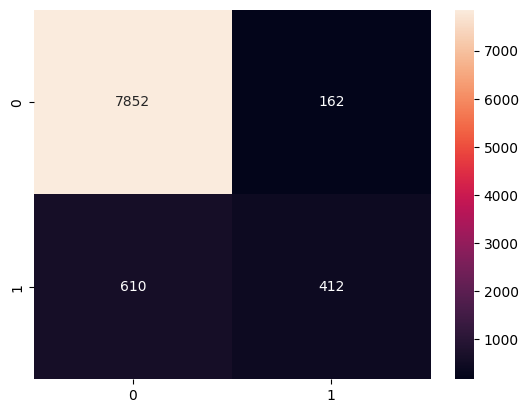

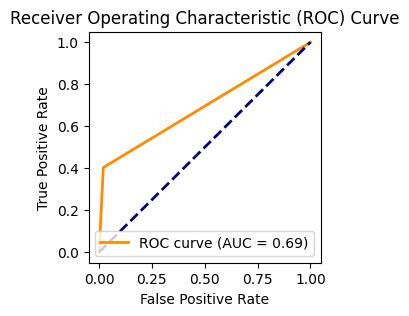

In [21]:
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import roc_curve, auc

import seaborn as sns

def getAllMetrics(y_pred, y_test):

    #Classification report
    report = sklearn.metrics.classification_report(y_test, y_pred, digits=4, zero_division='warn')
    print(report)

    #Confussion matrix
    print('Confusion matrix')
    cf_mat = sklearn.metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_mat, annot=True,fmt="d")
    plt.show()

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(3,3))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

getAllMetrics(test_predict, y_test)